In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
n_bandits = 100
n_tries = 10000

np.random.seed(123)
p_true = np.random.rand(n_bandits) * .8  # average around 40%
p_true.mean()

0.40114310404118503

In [3]:
n_runs = 20
stats = []

#### explore and commit

In [4]:
frac_explore = [.01, .05, .1, .15, .2]  # 10 or 15% seems best (can you prove this?)

for _ in range(n_runs):
    for frac in frac_explore:
        # explore and commit
        n_explore = int(frac * n_tries)
        n0, w0 = 2, 1  # similar to 50% to smooth it out
        n_draws = np.zeros(n_bandits)
        n_wins = np.zeros(n_bandits)
        series = []
        
        for i in range(n_explore):  # explore
            pick = i % n_bandits
            n_draws[pick] += 1
            n_wins[pick] += np.random.rand() < p_true[pick]
            series.append(n_wins.sum())
        p_pred = (n_wins + w0) / (n_draws + n0)            
        # p_pred = n_wins / n_draws
        
        pick = p_pred.argmax()  # commit
        for i in range(n_explore, n_tries):  
            n_draws[pick] += 1
            n_wins[pick] += np.random.rand() < p_true[pick]
            series.append(n_wins.sum())
        
        wins = n_wins.sum()
        avg_win = wins / n_draws.sum()  # should be same as n_tries
    
        stats.append({'algorithm': 'explore & commit', 'param': frac, 'wins': wins, 'tries': n_draws.sum(), 'series': series})

In [5]:
pd.DataFrame(stats).groupby(['algorithm'])['wins'].mean().sort_values(ascending=False) / n_tries

algorithm
explore & commit    0.62059
Name: wins, dtype: float64

#### epsilon greedy

In [6]:
epsilons = [.01, .05, .1, .15, .2]

for _ in range(n_runs):
    for eps in epsilons:
        n0, w0 = 2, 1  # similar to 50% to smooth it out
        n_draws = np.zeros(n_bandits)
        n_wins = np.zeros(n_bandits)       
        series = []
        for i in range(n_tries):  
            if np.random.rand() < eps:  # explore
                pick = np.random.choice(n_bandits)
            else:  # exploit
                # p_pred = n_wins / n_draws
                p_pred = (n_wins + w0) / (n_draws + n0)
                pick = p_pred.argmax()
                
            n_draws[pick] += 1
            n_wins[pick] += np.random.rand() < p_true[pick]
            series.append(n_wins.sum())
            
        wins = n_wins.sum()
        avg_win = wins / n_draws.sum()  # should be same as n_tries
    
        stats.append({'algorithm': 'epsilon greedy', 'param': eps, 'wins': wins, 'tries': n_draws.sum(), 'series': series})

In [7]:
pd.DataFrame(stats).groupby(['algorithm'])['wins'].mean().sort_values(ascending=False) / n_tries

algorithm
epsilon greedy      0.726583
explore & commit    0.620590
Name: wins, dtype: float64

In [8]:
pd.DataFrame(stats).groupby(['algorithm', 'param'], dropna=False)['wins'].mean().unstack() / n_tries

param,0.01,0.05,0.10,0.15,0.20
algorithm,,,,,
epsilon greedy,0.733005,0.75239,0.731845,0.714635,0.701040
explore & commit,0.452905,0.63931,0.657920,0.674180,0.678635


### Boltzmann, softmax

In [9]:
for _ in range(n_runs):
    n0, w0 = 2, 1  # similar to 50% to smooth it out
    n_draws = np.zeros(n_bandits)
    n_wins = np.zeros(n_bandits)       
    series = []

    for i in range(n_tries):  
        p_pred = (n_wins + w0) / (n_draws + n0)
        p_pick = p_pred / p_pred.sum()  # softmax sampling
        pick = np.random.choice(n_bandits, p=p_pick)
        n_draws[pick] += 1
        n_wins[pick] += np.random.rand() < p_true[pick]
        series.append(n_wins.sum())
        
    wins = n_wins.sum()
    avg_win = wins / n_draws.sum()  # should be same as n_tries

    stats.append({'algorithm': 'boltzmann', 'param': None, 'wins': wins, 'tries': n_draws.sum(), 'series': series})

In [10]:
pd.DataFrame(stats).groupby(['algorithm'])['wins'].mean().sort_values(ascending=False) / n_tries

algorithm
epsilon greedy      0.726583
explore & commit    0.620590
boltzmann           0.486615
Name: wins, dtype: float64

#### UCB

In [11]:
alphas = [.01, .05, .1, .15, .2]

for _ in range(n_runs):
    for alpha in alphas:
        z = st.norm.ppf(1 - alpha / 2)

        # smooth this to prevent division by zero
        n0, w0 = 2, 1  # similar to 50%
        # n0, w0 = 0, 0  # division by zero but undefined
        n_draws = np.zeros(n_bandits)
        n_wins = np.zeros(n_bandits)
        series = []
        
        for i in range(n_tries):  
            p_pred = (n_wins + w0) / (n_draws + n0)
            err = z * np.sqrt(p_pred * (1 - p_pred) / (n_draws + n0))
            pick = (p_pred + err).argmax()  # pick upper confidence bound
                
            n_draws[pick] += 1
            n_wins[pick] += np.random.rand() < p_true[pick]
            series.append(n_wins.sum())
            
        wins = n_wins.sum()
        avg_win = wins / n_draws.sum()  # should be same as n_tries
    
        stats.append({'algorithm': 'UCB', 'param': alpha, 'wins': wins, 'tries': n_draws.sum(), 'series': series})

In [12]:
pd.DataFrame(stats).groupby(['algorithm', 'param'], dropna=False)['wins'].mean().unstack() / n_tries

param,0.01,0.05,0.10,0.15,0.20,NaN
algorithm,,,,,,
UCB,0.754520,0.76586,0.778965,0.776155,0.777900,NaN
boltzmann,NaN,NaN,NaN,NaN,NaN,0.486615
epsilon greedy,0.733005,0.75239,0.731845,0.714635,0.701040,NaN
explore & commit,0.452905,0.63931,0.657920,0.674180,0.678635,NaN


#### Thompson

In [13]:
for _ in range(n_runs):

    # smooth this to prevent division by zero
    n0, w0 = 2, 1  # similar to 50%
    n_draws = np.zeros(n_bandits)
    n_wins = np.zeros(n_bandits)
    series = []
    
    for i in range(n_tries):
        a, b = n_wins + w0, n_draws + n0 - n_wins + w0
        p_pred = np.random.beta(a, b)  # sample from distribution
        pick = p_pred.argmax()  # pick highest sample
        n_draws[pick] += 1
        n_wins[pick] += np.random.rand() < p_true[pick]
        series.append(n_wins.sum())
        
    wins = n_wins.sum()
    avg_win = wins / n_draws.sum()  # should be same as n_tries

    stats.append({'algorithm': 'Thompson', 'param': None, 'wins': wins, 'tries': n_draws.sum(), 'series': series})

In [14]:
pd.DataFrame(stats).groupby(['algorithm', 'param'], dropna=False)['wins'].mean().unstack() / n_tries 

param,0.01,0.05,0.10,0.15,0.20,NaN
algorithm,,,,,,
Thompson,NaN,NaN,NaN,NaN,NaN,0.749840
UCB,0.754520,0.76586,0.778965,0.776155,0.777900,NaN
boltzmann,NaN,NaN,NaN,NaN,NaN,0.486615
epsilon greedy,0.733005,0.75239,0.731845,0.714635,0.701040,NaN
explore & commit,0.452905,0.63931,0.657920,0.674180,0.678635,NaN


#### plots

In [15]:
df = pd.DataFrame(stats)
assert df['tries'].min() == n_tries  # making sure no bugs

# clean up names and things
df['algorithm'] = df['algorithm'].str.title().str.replace('Ucb', 'UCB')
df['algo_with_param'] = df['algorithm'] + df['param'].map(lambda x: "" if np.isnan(x) else "-%s" % x)

# pick results from the best params
algo_with_params = df.groupby(['algorithm', 'algo_with_param'], dropna=False)['wins'].mean().unstack().T.idxmax().values
algo_with_params = df.groupby('algo_with_param')['wins'].mean().loc[algo_with_params].sort_values().index  # sort by performance
algorithms = [algo.split('-')[0] for algo in algo_with_params]

# create summary table with best versions
df['series'] = df['series'].map(np.array)
df = df.groupby('algo_with_param')['series'].mean()
df = pd.DataFrame(np.array(df.values.tolist()), index=df.index).T
n = np.arange(len(df)) + 1
df = df.div(n, axis=0)
df.tail(3)

algo_with_param,Boltzmann,Epsilon Greedy-0.01,Epsilon Greedy-0.05,Epsilon Greedy-0.1,Epsilon Greedy-0.15,Epsilon Greedy-0.2,Explore & Commit-0.01,Explore & Commit-0.05,Explore & Commit-0.1,Explore & Commit-0.15,Explore & Commit-0.2,Thompson,UCB-0.01,UCB-0.05,UCB-0.1,UCB-0.15,UCB-0.2
9997,0.486607,0.733007,0.752405,0.731846,0.714653,0.70105,0.452911,0.639318,0.657887,0.674170,0.678621,0.749835,0.754526,0.765838,0.778961,0.776170,0.777891
9998,0.486614,0.732993,0.752380,0.731843,0.714636,0.70104,0.452910,0.639299,0.657911,0.674177,0.678628,0.749835,0.754520,0.765847,0.778968,0.776158,0.777903
9999,0.486615,0.733005,0.752390,0.731845,0.714635,0.70104,0.452905,0.639310,0.657920,0.674180,0.678635,0.749840,0.754520,0.765860,0.778965,0.776155,0.777900


In [16]:
my_colors = np.array(sns.color_palette())[[0, 1, 3, 6, 7]]
colors = dict(zip(algorithms, my_colors))
for col in df:
    colors[col] = colors[col.split('-')[0]]
# colors

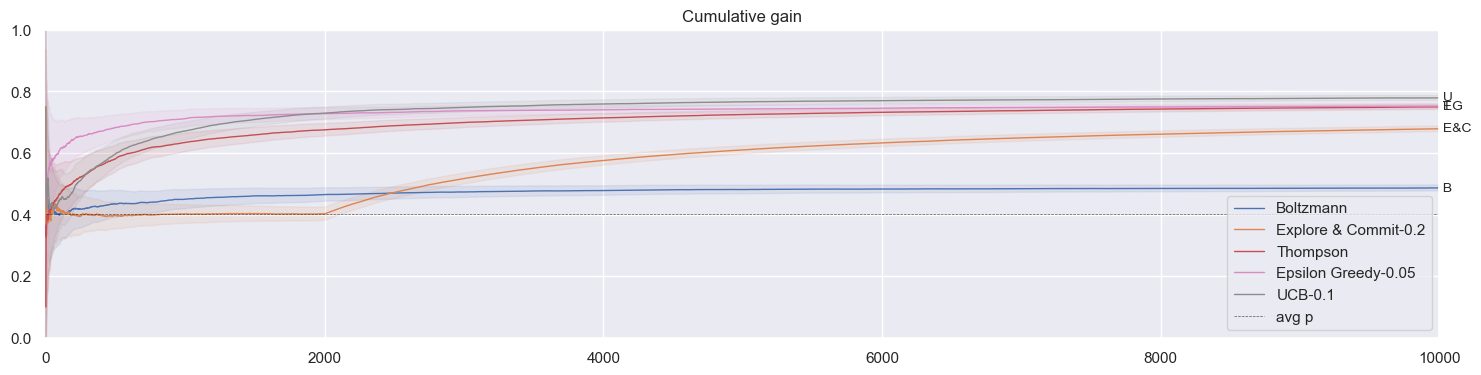

In [17]:
ax = df[algo_with_params].plot(figsize=(18, 4), lw=1, color=colors)
err = 1.96 * np.sqrt((df * (1 - df)).div(n, axis=0))
for col in algo_with_params:
    ax.fill_between(df.index, df[col] + err[col], df[col] - err[col], color=colors[col], alpha=.1)
    is_ss_max_idx = (df[col] - err[col]) > (df[list(set(df.columns) - {col})] + err).max(axis=1)
    df[col][is_ss_max_idx].plot(color=colors[col], ax=ax, lw=3, label='')
    ax.text(df.index[-1], df[col].iloc[-1], ' %s' % (''.join([word[0] for word in col.split()])), va='center', fontsize=10)
ax.hlines(p_true.mean(), 0, n_tries, lw=.5, color='k', linestyles='--', alpha=.7, label='avg p')
ax.set_xlim(-10, n_tries), ax.set_ylim(0, 1)
ax.set_title('Cumulative gain')
_ = plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

(-1.0, 500.0)

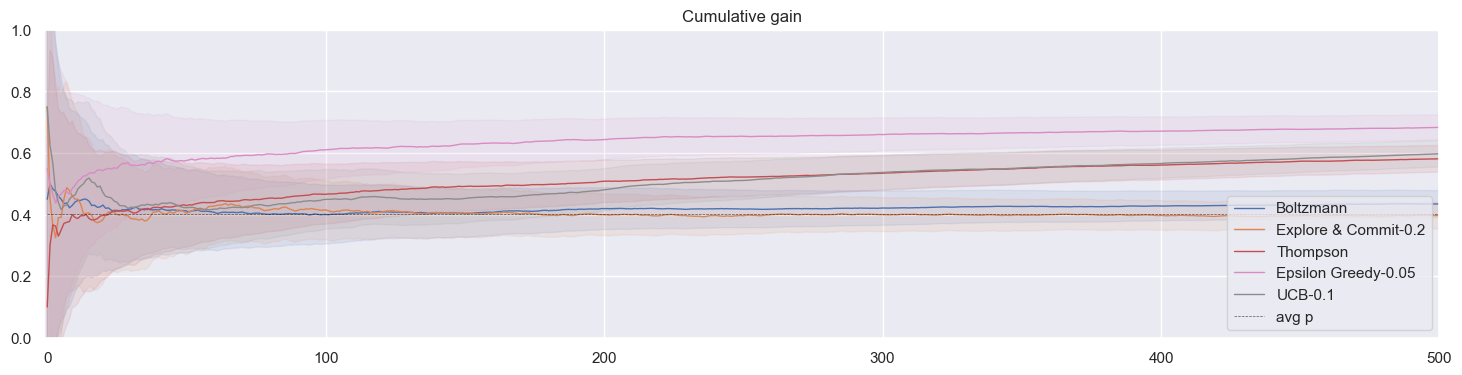

In [18]:
ax = df[algo_with_params].plot(figsize=(18, 4), lw=1, color=colors)
err = 1.96 * np.sqrt((df * (1 - df)).div(n, axis=0))
for col in algo_with_params:
    ax.fill_between(df.index, df[col] + err[col], df[col] - err[col], color=colors[col], alpha=.1)
    is_ss_max_idx = (df[col] - err[col]) > (df[list(set(df.columns) - {col})] + err).max(axis=1)
    df[col][is_ss_max_idx].plot(color=colors[col], ax=ax, lw=3, label='')
ax.hlines(p_true.mean(), 0, n_tries, lw=.5, color='k', linestyles='--', alpha=.7, label='avg p')
# ax.set_xlim(-10, n_tries), 
ax.set_ylim(0, 1)
ax.set_title('Cumulative gain')
_ = plt.legend(loc='lower right', bbox_to_anchor=(1, 0))

ax.set_xticks(np.arange(100) * n_bandits)
ax.set_xlim(-1, 5 * n_bandits)

In [19]:
# df

In [20]:
# algo_with_params
algo_map = {algo: algo.split('-')[0] for algo in df.columns}
algo_groups = pd.DataFrame(algo_map.items()).groupby(1)[0].unique().to_dict()
# algo_groups

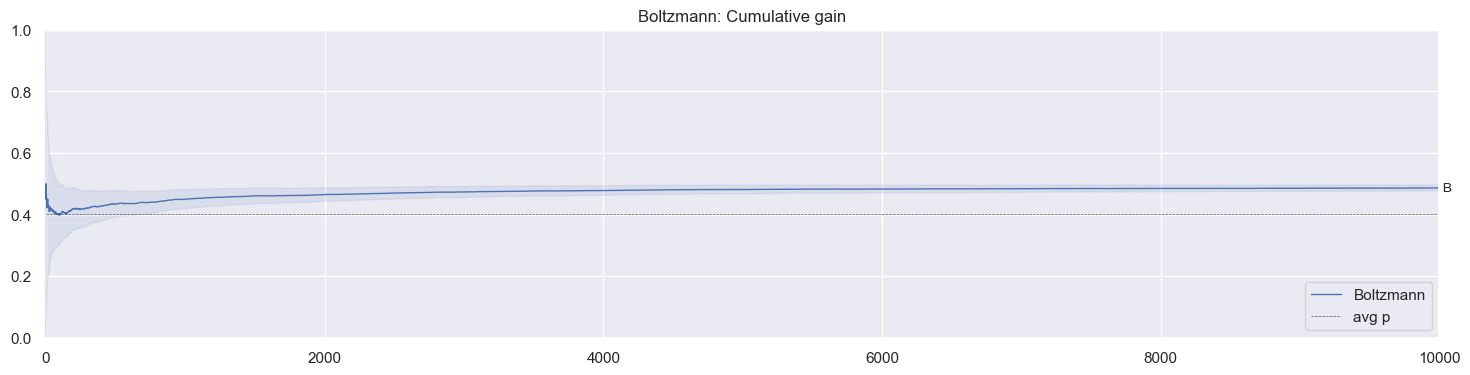

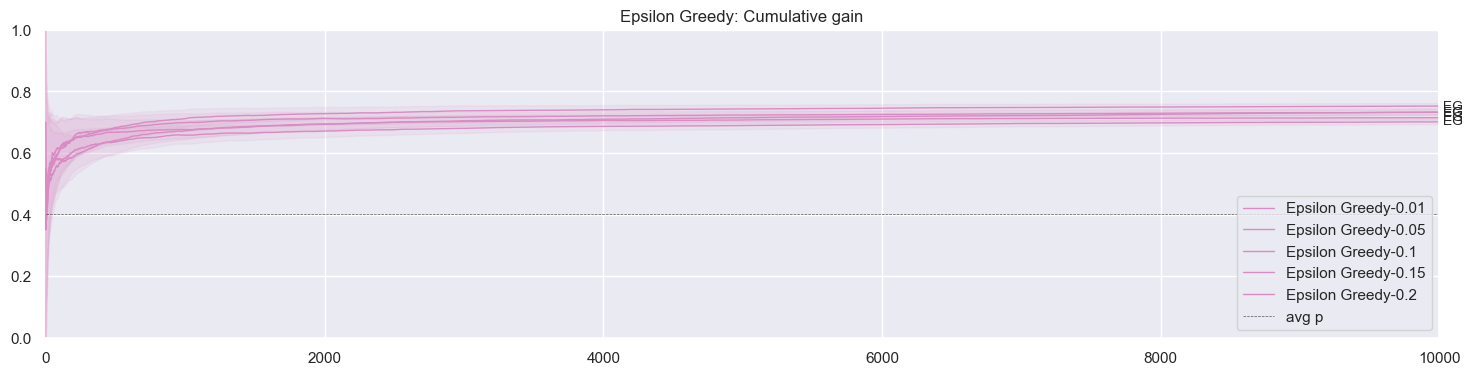

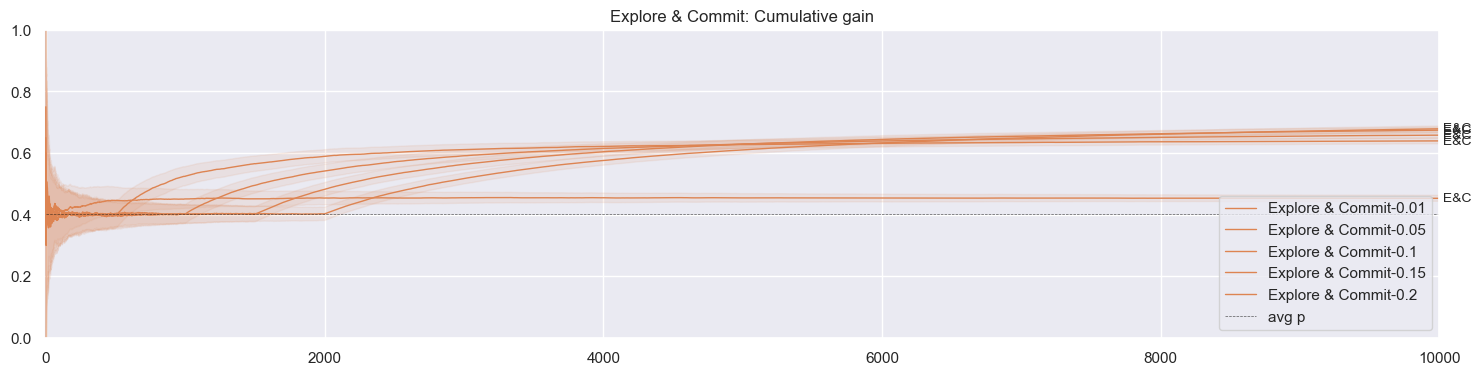

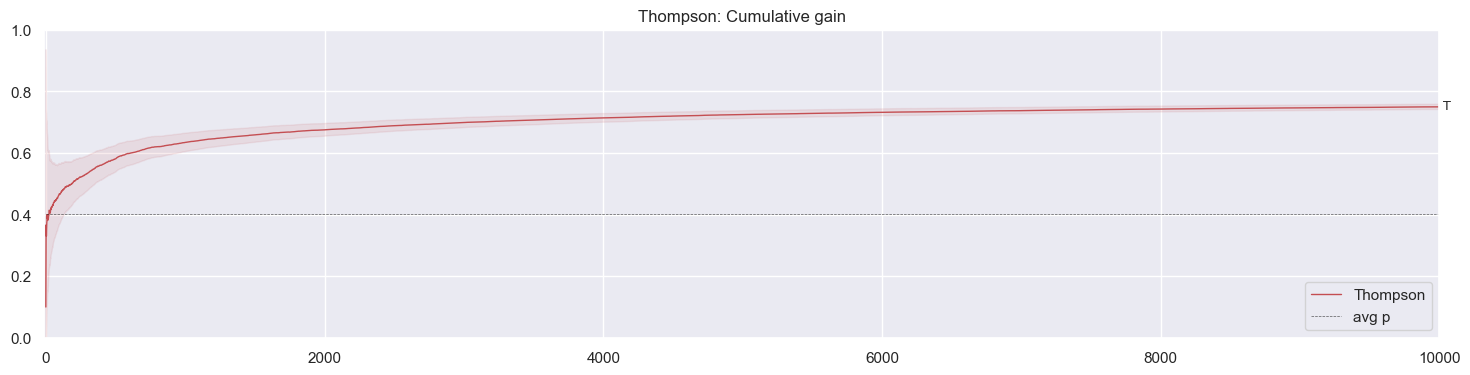

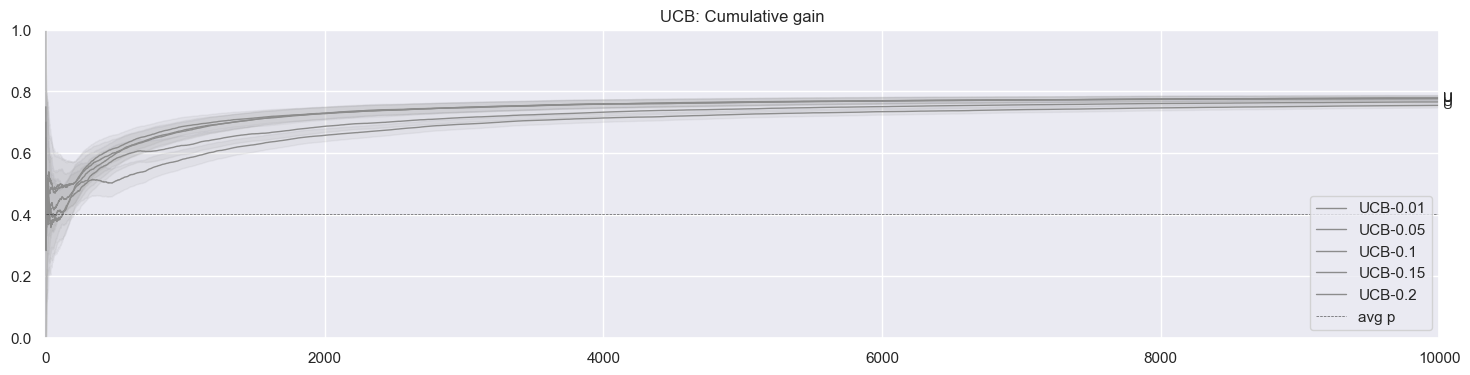

In [22]:
for algo, group in algo_groups.items():
    ax = df[group].plot(figsize=(18, 4), lw=1, color=colors)
    err = 1.96 * np.sqrt((df * (1 - df)).div(n, axis=0))
    for col in group:
        ax.fill_between(df.index, df[col] + err[col], df[col] - err[col], color=colors[col], alpha=.1)
        is_ss_max_idx = (df[col] - err[col]) > (df[list(set(df.columns) - {col})] + err).max(axis=1)
        df[col][is_ss_max_idx].plot(color=colors[col], ax=ax, lw=3, label='')
        ax.text(df.index[-1], df[col].iloc[-1], ' %s' % (''.join([word[0] for word in col.split()])), va='center', fontsize=10)
    ax.hlines(p_true.mean(), 0, n_tries, lw=.5, color='k', linestyles='--', alpha=.7, label='avg p')
    ax.set_xlim(-10, n_tries), ax.set_ylim(0, 1)
    ax.set_title('%s: Cumulative gain' % algo)
    _ = plt.legend(loc='lower right', bbox_to_anchor=(1, 0))